In [1]:
import numpy as np

# Load feature vectors
gait_features = np.load('/content/drive/MyDrive/gait_feature_vectors_rf.npy')
audio_features = np.load('/content/drive/MyDrive/audio_features.npy')
handwriting_features = np.load('/content/drive/MyDrive/Handwrting features.npy')

# Load labels
audio_labels = np.load('/content/drive/MyDrive/audio_labels.npy')
handwriting_labels = np.load('/content/drive/MyDrive/Handwriting labels.npy')

# Sanity check on shapes
print("Gait features shape:", gait_features.shape)
print("Audio features shape:", audio_features.shape)
print("Handwriting features shape:", handwriting_features.shape)
print("Audio labels shape:", audio_labels.shape)
print("Handwriting labels shape:", handwriting_labels.shape)


Gait features shape: (2485, 100)
Audio features shape: (81, 128)
Handwriting features shape: (72, 2048)
Audio labels shape: (81,)
Handwriting labels shape: (72,)


Final fused feature shape: (72, 2276)
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.67      0.80      0.73         5

    accuracy                           0.80        15
   macro avg       0.78      0.80      0.78        15
weighted avg       0.81      0.80      0.80        15



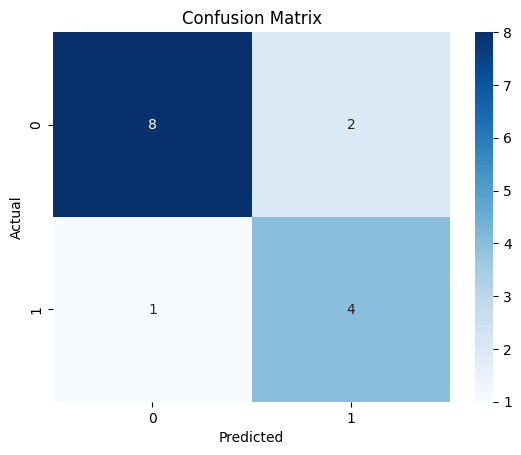

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Load feature vectors
audio_features = np.load('/content/drive/MyDrive/audio_features.npy')[:72]
handwriting_features = np.load('/content/drive/MyDrive/Handwrting features.npy')
gait_features = np.load('/content/drive/MyDrive/gait_feature_vectors_rf.npy')

# Downsample gait to 72 samples (uniform sampling)
indices = np.linspace(0, gait_features.shape[0]-1, 72).astype(int)
gait_downsampled = gait_features[indices]

# Normalize gait features (optional but often helpful)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
gait_downsampled = scaler.fit_transform(gait_downsampled)

# Concatenate all features
fused_features = np.concatenate((audio_features, handwriting_features, gait_downsampled), axis=1)
print("Final fused feature shape:", fused_features.shape)

# Load audio labels (first 72 samples)
labels = np.load('/content/drive/MyDrive/audio_labels.npy')[:72]

# Split data
X_train, X_test, y_train, y_test = train_test_split(fused_features, labels, test_size=0.2, random_state=42)

# Train classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [3]:
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# ----- MLP Classifier -----
mlp = MLPClassifier(hidden_layer_sizes=(256, 128), activation='relu', max_iter=300, random_state=42)
mlp.fit(X_train, y_train)
mlp_preds = mlp.predict(X_test)
print("\n🔹 MLP Classifier Report:\n", classification_report(y_test, mlp_preds))

# ----- XGBoost Classifier -----
xgb = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)
print("\n🔹 XGBoost Classifier Report:\n", classification_report(y_test, xgb_preds))

# Optional: Compare accuracy
print("Accuracy Scores:")
print(f"  Random Forest: {accuracy_score(y_test, y_pred):.2f}")
print(f"  MLP:           {accuracy_score(y_test, mlp_preds):.2f}")
print(f"  XGBoost:       {accuracy_score(y_test, xgb_preds):.2f}")



🔹 MLP Classifier Report:
               precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       0.62      1.00      0.77         5

    accuracy                           0.80        15
   macro avg       0.81      0.85      0.80        15
weighted avg       0.88      0.80      0.81        15



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:34:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔹 XGBoost Classifier Report:
               precision    recall  f1-score   support

           0       1.00      0.60      0.75        10
           1       0.56      1.00      0.71         5

    accuracy                           0.73        15
   macro avg       0.78      0.80      0.73        15
weighted avg       0.85      0.73      0.74        15

Accuracy Scores:
  Random Forest: 0.80
  MLP:           0.80
  XGBoost:       0.73


## INPUT CHECK:

In [4]:
import numpy as np
import librosa
import cv2
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from xgboost import XGBClassifier
import joblib
import os

In [16]:
import numpy as np
import librosa
import cv2
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
import joblib  # To load scaler
from xgboost import XGBClassifier  # Or use MLPClassifier or RandomForestClassifier
import pickle  # If your model was saved using pickle

# --- 1. Extract audio features ---
def extract_audio_features(file_path):
    y, sr = librosa.load(file_path, sr=22050)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    mel_db = librosa.power_to_db(mel_spec, ref=np.max)
    mel_resized = cv2.resize(mel_db, (224, 224), interpolation=cv2.INTER_CUBIC)
    mel_rgb = np.stack([mel_resized] * 3, axis=-1)
    mel_rgb = np.expand_dims(mel_rgb, axis=0)
    mel_rgb = preprocess_input(mel_rgb.astype(np.float32))
    cnn = ResNet50(weights='imagenet', include_top=False, pooling='avg')
    features = cnn.predict(mel_rgb)
    return features  # shape: (1, 2048)

# --- 2. Extract handwriting image features ---
def extract_image_features(img_path):
    from tensorflow.keras.applications import ResNet50
    from tensorflow.keras.applications.resnet50 import preprocess_input

    model = ResNet50(weights='imagenet', include_top=False, pooling='avg', input_shape=(224, 224, 3))

    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    features = model.predict(img_array)  # shape: (1, 2048)

    return features[:, :128]  # Only keep the first 128 dims


# --- 3. Process gait from file ---
def process_gait_record_from_file(file_path, scaler):
    with open(file_path, 'r') as f:
        first_line = f.readline().strip()
    values = first_line.split(',')[2:]  # Skip index and time
    values = [float(x.strip()) for x in values if x.strip()]
    values = values[:100]
    if len(values) < 100:
        values += [0.0] * (100 - len(values))
    gait_array = np.array(values).reshape(1, -1)
    gait_scaled = scaler.transform(gait_array)
    return gait_scaled

# --- 4. Predict with all models ---
def predict_multimodal(audio_path, image_path, gait_path, scaler, clf, mlp, xgb):
    audio_feat = extract_audio_features(audio_path)
    image_feat = extract_image_features(image_path)
    gait_feat = process_gait_record_from_file(gait_path, scaler)

    fused = np.concatenate((audio_feat, image_feat, gait_feat), axis=1)

    rf_pred = clf.predict(fused)[0]
    mlp_pred = mlp.predict(fused)[0]
    xgb_pred = xgb.predict(fused)[0]

    print("🔹 Random Forest Prediction:", rf_pred)
    print("🔹 MLP Prediction:          ", mlp_pred)
    print("🔹 XGBoost Prediction:      ", xgb_pred)

    return rf_pred, mlp_pred, xgb_pred
# ======================
# 🔽 Example Usage Below
# ======================

# Step 1: Paths to new input files
audio_path = '/content/drive/MyDrive/parkinson voice/HC_AH/AH_064F_7AB034C9-72E4-438B-A9B3-AD7FDA1596C5.wav'
image_path = '/content/V01HE01.png'
gait_path = '/content/drive/MyDrive/Filtered Data/001/task_1.txt'

# Step 2: Load scaler and model (must be same as used in training)
# scaler = joblib.load('/content/drive/MyDrive/gait_scaler.pkl')

# # Option 1: Load XGBoost model
# model = joblib.load('/content/drive/MyDrive/xgb_model.pkl')

# Option 2: Load RandomForest or MLPClassifier if needed
# with open('/content/drive/MyDrive/rf_model.pkl', 'rb') as f:
#     model = pickle.load(f)

# Step 3: Predict

# Predict using already trained in-memory models and scaler
predict_multimodal(audio_path, image_path, gait_path, scaler, clf, mlp, xgb)







1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
🔹 Random Forest Prediction: 0
🔹 MLP Prediction:           0
🔹 XGBoost Prediction:       1


(np.int64(0), np.int64(0), np.int64(1))

In [19]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

def display_prediction_result(model_name, pred, prob):
    verdict = "🧠 Parkinson's Detected" if pred == 1 else "✅ No Parkinson's"
    confidence = f"{np.max(prob) * 100:.2f}%"
    print(f"🔍 {model_name} Prediction: {verdict} (Confidence: {confidence})")

def predict_multimodal_with_verdict(audio_path, image_path, gait_path, scaler, rf_model, mlp_model, xgb_model):
    # --- Extract Features ---
    audio_feat = extract_audio_features(audio_path)
    image_feat = extract_image_features(image_path)  # Already truncated to 128 dims
    gait_feat = process_gait_record_from_file(gait_path, scaler)

    # --- Fuse All Features ---
    fused = np.concatenate((audio_feat, image_feat, gait_feat), axis=1)

    # --- Predict with each model ---
    rf_prob = rf_model.predict_proba(fused)[0]
    mlp_prob = mlp_model.predict_proba(fused)[0]
    xgb_prob = xgb_model.predict_proba(fused)[0]

    rf_pred = np.argmax(rf_prob)
    mlp_pred = np.argmax(mlp_prob)
    xgb_pred = np.argmax(xgb_prob)

    # --- Display Results ---
    print("\n📊 Individual Model Predictions:")
    display_prediction_result("Random Forest", rf_pred, rf_prob)
    display_prediction_result("MLP Neural Net", mlp_pred, mlp_prob)
    display_prediction_result("XGBoost", xgb_pred, xgb_prob)

    # --- Final Verdict (weighted majority vote based on probabilities) ---
    combined_probs = (rf_prob + mlp_prob + xgb_prob) / 3
    final_pred = np.argmax(combined_probs)
    final_confidence = combined_probs[final_pred] * 100

    label_map = {0: "✅ No Parkinson's", 1: "🧠 Parkinson's Detected"}
    print("\n🧾 Final Verdict (Consensus):")
    print(f"➡️ {label_map[final_pred]} (Consensus Confidence: {final_confidence:.2f}%)")

audio_path = '/content/drive/MyDrive/parkinson voice/HC_AH/AH_064F_7AB034C9-72E4-438B-A9B3-AD7FDA1596C5.wav'
image_path = '/content/V01HE01.png'
gait_path = '/content/drive/MyDrive/Filtered Data/001/task_1.txt'

# Step 2: Load scaler and model (must be same as used in training)
# scaler = joblib.load('/content/drive/MyDrive/gait_scaler.pkl')

# # Option 1: Load XGBoost model
# model = joblib.load('/content/drive/MyDrive/xgb_model.pkl')

# Option 2: Load RandomForest or MLPClassifier if needed
# with open('/content/drive/MyDrive/rf_model.pkl', 'rb') as f:
#     model = pickle.load(f)

# Step 3: Predict

# Predict using already trained in-memory models and scaler
predict_multimodal_with_verdict(audio_path, image_path, gait_path, scaler, clf, mlp, xgb)




1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

📊 Individual Model Predictions:
🔍 Random Forest Prediction: ✅ No Parkinson's (Confidence: 51.00%)
🔍 MLP Neural Net Prediction: ✅ No Parkinson's (Confidence: 66.16%)
🔍 XGBoost Prediction: 🧠 Parkinson's Detected (Confidence: 67.86%)

🧾 Final Verdict (Consensus):
➡️ 🧠 Parkinson's Detected (Consensus Confidence: 50.23%)


weighted voting approach based on the probability/confidence scores predicted by each model.Since avg_prob_yes = 0.5023 is slightly higher than avg_prob_no = 0.4977, the final prediction becomes:

🧾 Final Verdict: Parkinson's Detected
Consensus Confidence = 50.23%

